In [1]:
import os
import math
import random

import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim

C:\Anaconda\envs\py3\lib\site-packages\tensorflow\python\framework\dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda\envs\py3\lib\site-packages\tensorflow\python\framework\dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda\envs\py3\lib\site-packages\tensorflow\python\framework\dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda\envs\py3\lib\site-packages\tensorflow\python\framework\dtypes.py:461: FutureWarning: Passing (type, 1) or 

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
import sys
sys.path.append('../')

In [4]:
from nets import ssd_vgg_300, ssd_common, np_methods
from preprocessing import ssd_vgg_preprocessing
from notebooks import visualization

In [5]:
# TensorFlow session: grow memory when needed. TF, DO NOT USE ALL MY GPU MEMORY!!!
gpu_options = tf.GPUOptions(allow_growth=True)
config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
isess = tf.InteractiveSession(config=config)

## SSD 300 Model

The SSD 300 network takes 300x300 image inputs. In order to feed any image, the latter is resize to this input shape (i.e.`Resize.WARP_RESIZE`). Note that even though it may change the ratio width / height, the SSD model performs well on resized images (and it is the default behaviour in the original Caffe implementation).

SSD anchors correspond to the default bounding boxes encoded in the network. The SSD net output provides offset on the coordinates and dimensions of these anchors.

## Post-processing pipeline

The SSD outputs need to be post-processed to provide proper detections. Namely, we follow these common steps:

* Select boxes above a classification threshold;
* Clip boxes to the image shape;
* Apply the Non-Maximum-Selection algorithm: fuse together boxes whose Jaccard score > threshold;
* If necessary, resize bounding boxes to original image shape.

In [6]:
# Input placeholder.
net_shape = (300, 300)
data_format = 'NHWC'
img_input = tf.placeholder(tf.uint8, shape=(None, None, 3))
# Evaluation pre-processing: resize to SSD net shape.
image_pre, labels_pre, bboxes_pre, bbox_img = ssd_vgg_preprocessing.preprocess_for_eval(
    img_input, None, None, net_shape, data_format, resize=ssd_vgg_preprocessing.Resize.WARP_RESIZE)
image_4d = tf.expand_dims(image_pre, 0)

# Define the SSD model.
reuse = True if 'ssd_net' in locals() else None
ssd_net = ssd_vgg_300.SSDNet()
with slim.arg_scope(ssd_net.arg_scope(data_format=data_format)):
    predictions, localisations, _, _ = ssd_net.net(image_4d, is_training=False, reuse=reuse)

# Restore SSD model.
# ckpt_filename = '../checkpoints/ssd_300_vgg.ckpt'
ckpt_filename = 'D:\\MasterThesis\\NailDetection\\nail_model\\model.ckpt-7246'
# ckpt_filename = '../checkpoints/VGG_VOC0712_SSD_300x300_ft_iter_120000.ckpt'
isess.run(tf.global_variables_initializer())
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

# SSD default anchor boxes.
ssd_anchors = ssd_net.anchors(net_shape)

INFO:tensorflow:Restoring parameters from D:\MasterThesis\NailDetection\nail_model\model.ckpt-7246


In [7]:
# Main image processing routine.
def process_image(img, select_threshold=0.5, nms_threshold=.45, net_shape=(300, 300)):
    # Run SSD network.
    rimg, rpredictions, rlocalisations, rbbox_img = isess.run([image_4d, predictions, localisations, bbox_img],
                                                              feed_dict={img_input: img})
    
    # Get classes and bboxes from the net outputs.
    rclasses, rscores, rbboxes = np_methods.ssd_bboxes_select(
            rpredictions, rlocalisations, ssd_anchors,
            select_threshold=select_threshold, img_shape=net_shape, num_classes=21, decode=True)
    
    rbboxes = np_methods.bboxes_clip(rbbox_img, rbboxes)
    rclasses, rscores, rbboxes = np_methods.bboxes_sort(rclasses, rscores, rbboxes, top_k=400)
    rclasses, rscores, rbboxes = np_methods.bboxes_nms(rclasses, rscores, rbboxes, nms_threshold=nms_threshold)
    # Resize bboxes to original image shape. Note: useless for Resize.WARP!
    rbboxes = np_methods.bboxes_resize(rbbox_img, rbboxes)
    return rclasses, rscores, rbboxes

2


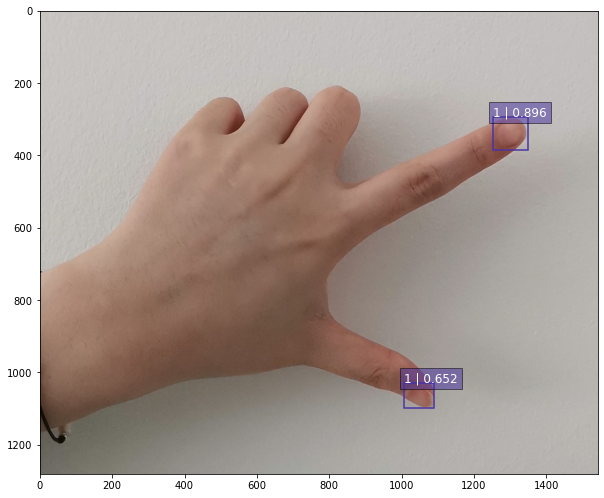

In [14]:
# Test on some demo image and visualize output.
# path = 'D:\\MasterThesis\\dataAndLabel\\'
path = 'D:\\MasterThesis\\test\\images\\'
image_names = sorted(os.listdir(path))
num = 1
img = mpimg.imread(path + '3b22.jpg')
rclasses, rscores, rbboxes =  process_image(img)
print(len(rclasses))
# visualization.bboxes_draw_on_img(img, rclasses, rscores, rbboxes, visualization.colors_plasma)
visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

In [11]:
# Test on some demo image and visualize output.
path = 'D:\\MasterThesis\\dataAndLabel\\'
image_names = sorted(os.listdir(path))
correct = 0
errorNames = []
for img_name in image_names:
    img = mpimg.imread(path + img_name)
    rclasses, rscores, rbboxes =  process_image(img)
    if int(img_name[-6]) == len(rclasses):
        correct = correct + 1
    else: 
        errorNames.append(img_name)
        print(img_name, img_name[-6], len(rclasses))
#         visualization.plt_bboxes(img, rclasses, rscores, rbboxes)

print("correct number:", correct)
print("accurancy:", correct/len(image_names))
    


117b33.jpg 3 2
16b44.jpg 4 3
171b55.jpg 5 3
218g32.jpg 3 2
254b11.jpg 1 0
256b22.jpg 2 1
267g23.jpg 2 0
295g13.jpg 1 0
37s23.jpg 2 0
43g23.jpg 2 1
56s23.jpg 2 1
8g14.jpg 1 0
correct number: 288
accurancy: 0.96


In [12]:
# Test on some demo image and visualize output.
path = 'D:\\MasterThesis\\dataAndLabel\\'
image_names = os.listdir(path)
fileName = set(image_names).difference(set(errorNames))
b,g,s = 0,0,0

for img_name in fileName:
    img = mpimg.imread(path + img_name)
    if img_name[-7] == 'b':
        b = b + 1
    elif img_name[-7] == 'g':
        g = g + 1
    elif img_name[-7] == 's':
        s = s + 1

print("b", b)
print("g", g)
print("s", s)
print("total:", len(image_names))
# print("b", 58)
# print("g", 53)
# print("s", 55)
# print("total:", 166)

b 121
g 82
s 85
total: 300


In [13]:
print(errorNames)

['117b33.jpg', '16b44.jpg', '171b55.jpg', '218g32.jpg', '254b11.jpg', '256b22.jpg', '267g23.jpg', '295g13.jpg', '37s23.jpg', '43g23.jpg', '56s23.jpg', '8g14.jpg']
